<a href="https://colab.research.google.com/github/eduardofae/RL/blob/main/AT-06/06%20-%20Eligibility%20traces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tarefa: Implementação e Comparação de Agentes SARSA

Nesta tarefa, você irá implementar o algoritmo SARSA com traços de elegibilidade (SARSA(lambda)) e compará-lo com o SARSA comum em um cenário específico. Em seguida, você treinará o agente SARSA(lambda) no grid para observar seu desempenho.

**Passos:**

1.  **Implementar o SARSA(lambda):** Complete a classe `SarsaLambdaAgent` para incluir a funcionalidade de traços de elegibilidade na função `updateQ`.
2.  **Comparação em um Episódio:** Execute o código fornecido que compara o SARSA comum e o SARSA(lambda) em um único episódio com uma sequência de ações pré-definida (`simple_episode_win` e `simple_episode_loss`). Observe como os valores Q aprendidos por cada agente se diferem após este episódio.
3.  **Treinamento do SARSA(lambda):** Treine o agente SARSA(lambda) com diferentes lambda no ambiente `GridWorld4x3`.



### Grid 4x3

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from typing import Optional,Iterable,Tuple
import matplotlib.pyplot as plt


class GridWorld4x3(gym.Env):
    metadata = {"render_modes": ["ansi"]}

    def __init__(
        self,
        reward_step: float = -0.04,
        slip: float = 0.2,
        max_steps: int = 1000,
        seed: Optional[int] = None,
        render_mode: Optional[str] = None,
    ):
        super().__init__()
        self.ncols = 4
        self.nrows = 3
        self.observation_space = spaces.Discrete(self.ncols * self.nrows)
        self.action_space = spaces.Discrete(4)  # 0=up, 1=right, 2=down, 3=left

        self.reward_step = reward_step
        self.slip = slip
        self.max_steps = max_steps
        self.render_mode = render_mode

        self.start_pos = (0, 0)
        self.goal_pos = (3, 2)  # state 11
        self.pit_pos = (3, 1)   # state 7
        self.wall_pos = (1, 1)  # state 5 (inacessível)

        self._rng = np.random.default_rng(seed)
        self.steps = 0
        self.agent_pos = self.start_pos

        # Movimentos: up, right, down, left
        self.moves = [(0, 1), (1, 0), (0, -1), (-1, 0)]

    # ---------- conversão estado/posição ----------
    def pos_to_state(self, pos):
        x, y = pos
        return y * self.ncols + x

    def state_to_pos(self, s):
        return (s % self.ncols, s // self.ncols)

    # ---------- helpers internos ----------
    def _move(self, pos, action):
        dx, dy = self.moves[action]
        x, y = pos
        new_pos = (x + dx, y + dy)
        # checa limites e parede
        if not (0 <= new_pos[0] < self.ncols and 0 <= new_pos[1] < self.nrows):
            return pos
        if new_pos == self.wall_pos:
            return pos
        return new_pos

    def _reward_and_done(self, pos):
        if pos == self.goal_pos:
            return 1.0, True
        elif pos == self.pit_pos:
            return -1.0, True
        return self.reward_step, False

    # ---------- API Gym ----------
    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        self.agent_pos = self.start_pos
        self.steps = 0
        return self.pos_to_state(self.agent_pos), {}

    def step(self, action):
        self.steps += 1

        # sorteia se escorrega
        if self._rng.random() < self.slip:
            if action in [0, 2]:  # up/down → troca por left/right
                action = self._rng.choice([1, 3])
            else:  # left/right → troca por up/down
                action = self._rng.choice([0, 2])

        self.agent_pos = self._move(self.agent_pos, action)
        reward, terminated = self._reward_and_done(self.agent_pos)
        truncated = self.steps >= self.max_steps

        return self.pos_to_state(self.agent_pos), reward, terminated, truncated, {}

    # ----------------------------
    # Rendering
    # ----------------------------
    def render(self, mode="ansi"):
        if mode == "ansi":
            return self._render_ansi()
        else:
            raise NotImplementedError

    def _render_ansi(self):
        out = ""
        for y in reversed(range(self.nrows)):
            out += "+----" * self.ncols + "+\n"
            for x in range(self.ncols):
                pos = (x, y)
                s = self.pos_to_state(pos)
                cell = f"{s:2d} "
                if pos == self.wall_pos:
                    cell = " ## "
                elif pos == self.goal_pos:
                    cell = f"{s:2d}G"
                elif pos == self.pit_pos:
                    cell = f"{s:2d}P"
                elif pos == self.start_pos:
                    cell = f"{s:2d}S"
                if self.agent_pos == self.state_to_pos(s):
                    cell = f"[{cell.strip()}]"
                out += f"|{cell:4}"
            out += "|\n"
        out += "+----" * self.ncols + "+\n"
        return out



## Código dos agentes

### TDAgent

In [ ]:
from abc import ABC,abstractmethod

class TDAgent(ABC):
    def __init__(self, env: gym.Env, alpha: float = 0.1, gamma: float = 0.99, epsilon: float = 0.1):
        """
        Construtor do agente TD.

        Args:
            env: ambiente Gymnasium (ex: gridworld 4x3).
            alpha: taxa de aprendizado.
            gamma: fator de desconto.
            epsilon: taxa de exploração (para política epsilon-greedy).
        """
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        obs_space_size = env.observation_space.n
        act_space_size = env.action_space.n
        self.q_values = np.zeros((obs_space_size, act_space_size))

    def Q(self, state, action) -> float:
      """Retorna Q(s,a)."""
      return self.q_values[state, action]

    def V(self, state) -> float:
      """Retorna V(s) = max_a Q(s,a)."""
      return np.max(self.q_values[state, :])

    def greedy_action(self, state) -> int:
      """Retorna a ação gulosa (argmax_a Q(s,a))."""
      return np.argmax(self.q_values[state, :])

    def act(self, state) -> int:
      """Retorna ação epsilon-greedy."""
      if np.random.rand() < self.epsilon:
          return self.env.action_space.sample()
      else:
          return self.greedy_action(state)

    @abstractmethod
    def train(self, steps: int):
      """
      Executa o treinamento por um número de passos.

      Args:
          steps: número de passos de treino.
      """
      pass





### Sarsa

In [ ]:
class SarsaAgent(TDAgent):
    def updateQ(self, s, a, r, s_next, a_next, done: bool):
        """Atualiza Q(s,a) segundo a regra do SARSA."""
        q_next = self.Q(s_next, a_next) if not done else 0
        self.q_values[s, a] += self.alpha * (r + self.gamma * q_next - self.Q(s, a))

    def train(self, steps: int):
        state, _ = self.env.reset()
        action = self.act(state)
        for step in range(steps):
            new_state, reward, terminated, truncated, _ = self.env.step(action)
            new_action = self.act(new_state)
            done = terminated or truncated
            self.updateQ(state, action, reward, new_state, new_action, done)
            state = new_state
            action = new_action
            if done:
                state, _ = self.env.reset()
                action = self.act(state)


### SarsaLambda

In [ ]:
class SarsaLambdaAgent(SarsaAgent):
    def __init__(self, env: gym.Env, alpha: float = 0.1, gamma: float = 0.99, epsilon: float = 0.1, lambda_: float = 0.9):
        """
        Construtor do agente SARSA(lambda).

        Args:
            env: ambiente Gymnasium (ex: gridworld 4x3).
            alpha: taxa de aprendizado.
            gamma: fator de desconto.
            epsilon: taxa de exploração (para política epsilon-greedy).
            lambda_: fator de decaimento para as trilhas de elegibilidade.
        """
        super().__init__(env, alpha, gamma, epsilon)
        self.lambda_ = lambda_
        # nao esqueca de atualizar os tracos de elegibilidade
        self.e = np.zeros((self.env.observation_space.n, self.env.action_space.n))

    def updateQ(self, s, a, r, s_next, a_next, done: bool):
        """Atualiza Q(s,a) segundo a regra do SARSA."""
        q_next = self.Q(s_next, a_next) if not done else 0
        delta = r + self.gamma * q_next - self.Q(s, a)
        self.e[s, a] = 1
        for s in range(self.env.observation_space.n):
            for a in range(self.env.action_space.n):
                self.q_values[s, a] += self.alpha * r * self.e[s, a]
                self.e[s,a] *= self.gamma * self.lambda_

    def train(self, steps: int):
        total_rewards = 0
        state, _ = self.env.reset()
        action = self.act(state)
        for step in range(steps):
            new_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            total_rewards += reward
            new_action = self.act(new_state)
            self.updateQ(state, action, reward, new_state, new_action, done)
            state = new_state
            action = new_action
            if done:
                state, _ = self.env.reset()
                action = self.act(state)
                self.e = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        return total_rewards


## Visualizador do agente

### Para o Grid 4x3

In [ ]:
class Grid4x3AgentVisualizer:
    def __init__(self, agent, env):
        """
        agent: ValueIterationAgent-like (tem V(s), Q(s,a) e greedy_action(s))
        env: GridWorld4x3-like (tem nrows, ncols, pos_to_state, state_to_pos, is_terminal, get_states, start_pos, goal_pos, pit_pos, wall_pos)
        """
        self.agent = agent
        self.env = env
        self.action_to_str = {0: "↑", 1: "→", 2: "↓", 3: "←"}

        # Precompute special states
        self.wall_s = self.env.pos_to_state(self.env.wall_pos)
        self.start_s = self.env.pos_to_state(self.env.start_pos)
        self.goal_s = self.env.pos_to_state(self.env.goal_pos)
        self.pit_s = self.env.pos_to_state(self.env.pit_pos)

    # -----------------------
    # Política (setas)
    # -----------------------
    def print_policy(self):
        rows, cols = self.env.nrows, self.env.ncols
        horiz = "+" + "+".join(["------"] * cols) + "+"

        for y in reversed(range(rows)):
            print(horiz)
            cells = []
            for x in range(cols):
                s = self.env.pos_to_state((x, y))
                if s == self.wall_s:
                    content = "##"
                elif s == self.goal_s:
                    content = " G "
                elif s == self.pit_s:
                    content = " P "
                else:
                    a = self.agent.greedy_action(s)
                    arrow = self.action_to_str.get(a, "?")
                    if s == self.start_s:
                        content = f"S{arrow}"
                    else:
                        content = arrow
                cells.append(f"{content:^6}")
            print("|" + "|".join(cells) + "|")
        print(horiz)

    # -----------------------
    # Valores V(s)
    # -----------------------
    def print_values(self):
        rows, cols = self.env.nrows, self.env.ncols
        horiz = "+" + "+".join(["--------"] * cols) + "+"

        for y in reversed(range(rows)):
            print(horiz)
            cells = []
            for x in range(cols):
                s = self.env.pos_to_state((x, y))
                if s == self.wall_s:
                    content = "####"
                else:
                    v = self.agent.V(s)
                    if s == self.goal_s:
                        content = f"G({v:.2f})"
                    elif s == self.pit_s:
                        content = f"P({v:.2f})"
                    else:
                        content = f"{v:6.2f}"
                cells.append(f"{content:^8}")
            print("|" + "|".join(cells) + "|")
        print(horiz)

    # -----------------------
    # Q-values
    # -----------------------
    def print_qvalues(self):
        rows, cols = self.env.nrows, self.env.ncols
        horiz = "+" + "+".join(["---------------"] * cols) + "+"

        for y in reversed(range(rows)):
            print(horiz)
            # três linhas por célula
            line1, line2, line3 = [], [], []
            for x in range(cols):
                s = self.env.pos_to_state((x, y))
                if s == self.wall_s:
                    c1 = "###############"
                    c2 = "###############"
                    c3 = "###############"
                else:
                    qvals = [self.agent.Q(s, a) for a in range(4)]
                    best = int(np.argmax(qvals))
                    up = f"↑:{qvals[0]:.2f}"
                    left = f"←:{qvals[3]:.2f}"
                    right = f"→:{qvals[1]:.2f}"
                    down = f"↓:{qvals[2]:.2f}"
                    c1 = f"{up:^15}"
                    c2 = f"{left:<7}{right:>8}"
                    c3 = f"{down:^15}"
                line1.append(c1)
                line2.append(c2)
                line3.append(c3)

            # agora cada linha recebe delimitadores
            print("|" + "|".join(line1) + "|")
            print("|" + "|".join(line2) + "|")
            print("|" + "|".join(line3) + "|")
        print(horiz)


## Executando os agentes



### Teste 1: episódios simples

Resultado esperado após acima, acima, dir, dir, dir (vitória):

```
Sarsa Agent Q-values after actions  [0, 0, 1, 1, 1]
+---------------+---------------+---------------+---------------+
|    ↑:0.00     |    ↑:0.00     |    ↑:0.00     |    ↑:0.00     |
|←:0.00   →:0.00|←:0.00   →:0.00|←:0.00   →:0.50|←:0.00   →:0.00|
|    ↓:0.00     |    ↓:0.00     |    ↓:0.00     |    ↓:0.00     |
+---------------+---------------+---------------+---------------+
|    ↑:0.00     |###############|    ↑:0.00     |    ↑:0.00     |
|←:0.00   →:0.00|###############|←:0.00   →:0.00|←:0.00   →:0.00|
|    ↓:0.00     |###############|    ↓:0.00     |    ↓:0.00     |
+---------------+---------------+---------------+---------------+
|    ↑:0.00     |    ↑:0.00     |    ↑:0.00     |    ↑:0.00     |
|←:0.00   →:0.00|←:0.00   →:0.00|←:0.00   →:0.00|←:0.00   →:0.00|
|    ↓:0.00     |    ↓:0.00     |    ↓:0.00     |    ↓:0.00     |
+---------------+---------------+---------------+---------------+

SarsaLambda Agent Q-Values actions:  [0, 0, 1, 1, 1]
+---------------+---------------+---------------+---------------+
|    ↑:0.00     |    ↑:0.00     |    ↑:0.00     |    ↑:0.00     |
|←:0.00   →:0.33|←:0.00   →:0.41|←:0.00   →:0.50|←:0.00   →:0.00|
|    ↓:0.00     |    ↓:0.00     |    ↓:0.00     |    ↓:0.00     |
+---------------+---------------+---------------+---------------+
|    ↑:0.27     |###############|    ↑:0.00     |    ↑:0.00     |
|←:0.00   →:0.00|###############|←:0.00   →:0.00|←:0.00   →:0.00|
|    ↓:0.00     |###############|    ↓:0.00     |    ↓:0.00     |
+---------------+---------------+---------------+---------------+
|    ↑:0.22     |    ↑:0.00     |    ↑:0.00     |    ↑:0.00     |
|←:0.00   →:0.00|←:0.00   →:0.00|←:0.00   →:0.00|←:0.00   →:0.00|
|    ↓:0.00     |    ↓:0.00     |    ↓:0.00     |    ↓:0.00     |
+---------------+---------------+---------------+---------------+
```

In [ ]:
simple_episode_win = [0, 0, 1, 1, 1] #up, up, right, right, right

env1 = GridWorld4x3(slip=0, reward_step=0)
env2 = GridWorld4x3(slip=0, reward_step=0)

sarsa_agent = SarsaAgent(env1, alpha=0.5, gamma=0.9, epsilon=0.1)
esarsa_agent = SarsaLambdaAgent(env2, alpha=0.5, gamma=0.9, epsilon=0.1, lambda_=0.9)

state1, _ = env1.reset()
state2, _ = env2.reset()

#run both agents
for i, action in enumerate(simple_episode_win):
    next_state, reward, terminated, truncated, _ = env1.step(action)
    done1 = terminated or truncated

    next_state2, reward2, terminated2, truncated2, _ = env2.step(action)
    done2 = terminated2 or truncated2

    if not (done1):
      next_action = simple_episode_win[i+1]
      next_action2 = simple_episode_win[i+1]
    else:
      next_action = None
      next_action2 = None

    sarsa_agent.updateQ(state1, action, reward, next_state, next_action, done1)
    esarsa_agent.updateQ(state2, action, reward2, next_state2, next_action2, done2)

    state1 = next_state
    state2 = next_state2


# Visualize what each agent learned after 1 episode
print("\nSarsa Agent Q-values after actions ", simple_episode_win)
grid_visualizer_sarsa = Grid4x3AgentVisualizer(sarsa_agent, env1)
grid_visualizer_sarsa.print_qvalues()

print("\nSarsaLambda Agent Q-Values actions: ", simple_episode_win)
grid_visualizer_sarsa_lambda = Grid4x3AgentVisualizer(esarsa_agent, env2)
grid_visualizer_sarsa_lambda.print_qvalues()



Sarsa Agent Q-values after actions  [0, 0, 1, 1, 1]
+---------------+---------------+---------------+---------------+
|    ↑:0.00     |    ↑:0.00     |    ↑:0.00     |    ↑:0.00     |
|←:0.00   →:0.00|←:0.00   →:0.00|←:0.00   →:0.50|←:0.00   →:0.00|
|    ↓:0.00     |    ↓:0.00     |    ↓:0.00     |    ↓:0.00     |
+---------------+---------------+---------------+---------------+
|    ↑:0.00     |###############|    ↑:0.00     |    ↑:0.00     |
|←:0.00   →:0.00|###############|←:0.00   →:0.00|←:0.00   →:0.00|
|    ↓:0.00     |###############|    ↓:0.00     |    ↓:0.00     |
+---------------+---------------+---------------+---------------+
|    ↑:0.00     |    ↑:0.00     |    ↑:0.00     |    ↑:0.00     |
|←:0.00   →:0.00|←:0.00   →:0.00|←:0.00   →:0.00|←:0.00   →:0.00|
|    ↓:0.00     |    ↓:0.00     |    ↓:0.00     |    ↓:0.00     |
+---------------+---------------+---------------+---------------+

SarsaLambda Agent Q-Values actions:  [0, 0, 1, 1, 1]
+---------------+---------------+--

#### Após mais um episódio

Executar esta celula após a anterior, pois a ideia é ver o conhecimento acumulado do agente após dois episódios.

Se rodar essa célula 2x seguidas, vc não obterá os resultados esperados.

Resultado esperado após dir, dir, dir, acima (derrota):
```
Sarsa Agent Q-values after actions  [1, 1, 1, 0]
+---------------+---------------+---------------+---------------+
|    ↑:0.00     |    ↑:0.00     |    ↑:0.00     |    ↑:0.00     |
|←:0.00   →:0.00|←:0.00   →:0.00|←:0.00   →:0.50|←:0.00   →:0.00|
|    ↓:0.00     |    ↓:0.00     |    ↓:0.00     |    ↓:0.00     |
+---------------+---------------+---------------+---------------+
|    ↑:0.00     |###############|    ↑:0.00     |    ↑:0.00     |
|←:0.00   →:0.00|###############|←:0.00   →:0.00|←:0.00   →:0.00|
|    ↓:0.00     |###############|    ↓:0.00     |    ↓:0.00     |
+---------------+---------------+---------------+---------------+
|    ↑:0.00     |    ↑:0.00     |    ↑:0.00     |    ↑:-0.50    |
|←:0.00   →:0.00|←:0.00   →:0.00|←:0.00   →:0.00|←:0.00   →:0.00|
|    ↓:0.00     |    ↓:0.00     |    ↓:0.00     |    ↓:0.00     |
+---------------+---------------+---------------+---------------+

SarsaLambda Agent Q-Values actions:  [1, 1, 1, 0]
+---------------+---------------+---------------+---------------+
|    ↑:0.00     |    ↑:0.00     |    ↑:0.00     |    ↑:0.00     |
|←:0.00   →:0.33|←:0.00   →:0.41|←:0.00   →:0.50|←:0.00   →:0.00|
|    ↓:0.00     |    ↓:0.00     |    ↓:0.00     |    ↓:0.00     |
+---------------+---------------+---------------+---------------+
|    ↑:0.27     |###############|    ↑:0.00     |    ↑:0.00     |
|←:0.00   →:0.00|###############|←:0.00   →:0.00|←:0.00   →:0.00|
|    ↓:0.00     |###############|    ↓:0.00     |    ↓:0.00     |
+---------------+---------------+---------------+---------------+
|    ↑:0.22     |    ↑:0.00     |    ↑:-0.22    |    ↑:-0.50    |
|←:0.00  →:-0.27|←:0.00  →:-0.33|←:0.00  →:-0.41|←:0.00   →:0.00|
|    ↓:0.00     |    ↓:0.00     |    ↓:0.00     |    ↓:0.00     |
+---------------+---------------+---------------+---------------+
```

In [ ]:
simple_episode_loss = [1, 1, 1, 0] #right, right, right up (defeat)

# executar esta celula após a anterior; se rodar essa 2x seguidas, vc não obterá os resultados esperados
state1, _ = env1.reset()
state2, _ = env2.reset()

#run both agents
for i, action in enumerate(simple_episode_loss):
    next_state, reward, terminated, truncated, _ = env1.step(action)
    done1 = terminated or truncated

    next_state2, reward2, terminated2, truncated2, _ = env2.step(action)
    done2 = terminated2 or truncated2

    if not (done1):
      next_action = simple_episode_loss[i+1]
      next_action2 = simple_episode_loss[i+1]
    else:
      next_action = None
      next_action2 = None

    sarsa_agent.updateQ(state1, action, reward, next_state, next_action, done1)
    esarsa_agent.updateQ(state2, action, reward2, next_state2, next_action2, done2)

    state1 = next_state
    state2 = next_state2


# Visualize what each agent learned after 1 episode
print("\nSarsa Agent Q-values after actions ", simple_episode_loss)
grid_visualizer_sarsa = Grid4x3AgentVisualizer(sarsa_agent, env1)
grid_visualizer_sarsa.print_qvalues()

print("\nSarsaLambda Agent Q-Values actions: ", simple_episode_loss)
grid_visualizer_sarsa_lambda = Grid4x3AgentVisualizer(esarsa_agent, env2)
grid_visualizer_sarsa_lambda.print_qvalues()



Sarsa Agent Q-values after actions  [1, 1, 1, 0]
+---------------+---------------+---------------+---------------+
|    ↑:0.00     |    ↑:0.00     |    ↑:0.00     |    ↑:0.00     |
|←:0.00   →:0.00|←:0.00   →:0.00|←:0.00   →:0.50|←:0.00   →:0.00|
|    ↓:0.00     |    ↓:0.00     |    ↓:0.00     |    ↓:0.00     |
+---------------+---------------+---------------+---------------+
|    ↑:0.00     |###############|    ↑:0.00     |    ↑:0.00     |
|←:0.00   →:0.00|###############|←:0.00   →:0.00|←:0.00   →:0.00|
|    ↓:0.00     |###############|    ↓:0.00     |    ↓:0.00     |
+---------------+---------------+---------------+---------------+
|    ↑:0.00     |    ↑:0.00     |    ↑:0.00     |    ↑:-0.50    |
|←:0.00   →:0.00|←:0.00   →:0.00|←:0.00   →:0.00|←:0.00   →:0.00|
|    ↓:0.00     |    ↓:0.00     |    ↓:0.00     |    ↓:0.00     |
+---------------+---------------+---------------+---------------+

SarsaLambda Agent Q-Values actions:  [1, 1, 1, 0]
+---------------+---------------+--------

### Treine seu agente no Grid 4x3

O grid terá os parâmetros: slip=0, reward_step=-0.1. Os agentes terão: alpha = 0.5, gamma = 0.9, epsilon = 0.1

Treine os agentes por 100 passos.

Analise as a políticas resultantes e os valores aprendidos para as seguintes lambdas: 0.1, 0.3, 0.5, 0.7, 0.9.

Execute 1000 repetições de cada experimento e gere um gráfico de barras com a recompensa média obtida para cada lambda (adapte sua função de treino pra retornar a recompensa acumulada pelo agente).




100%|██████████| 1000/1000 [00:35<00:00, 28.15it/s]


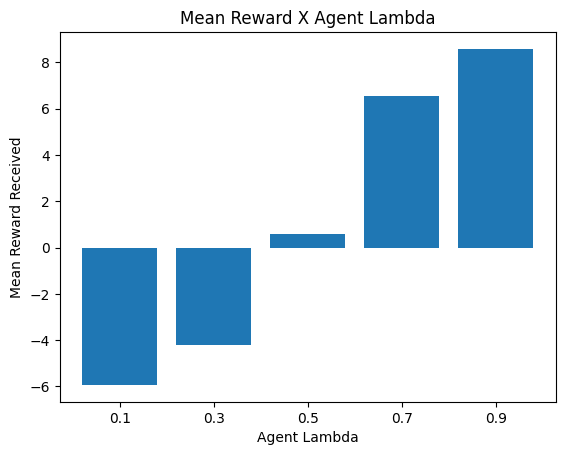


=== Política Aprendida (Lambda 0.1) ===
+------+------+------+------+
|  ←   |  →   |  →   |  G   |
+------+------+------+------+
|  ↑   |  ##  |  ↑   |  P   |
+------+------+------+------+
|  S→  |  ↓   |  ↓   |  ↓   |
+------+------+------+------+

=== Política Aprendida (Lambda 0.3) ===
+------+------+------+------+
|  ↓   |  →   |  →   |  G   |
+------+------+------+------+
|  ↓   |  ##  |  ↑   |  P   |
+------+------+------+------+
|  S←  |  →   |  ←   |  ↓   |
+------+------+------+------+

=== Política Aprendida (Lambda 0.5) ===
+------+------+------+------+
|  →   |  →   |  →   |  G   |
+------+------+------+------+
|  ↑   |  ##  |  ↑   |  P   |
+------+------+------+------+
|  S←  |  ←   |  ↑   |  ↓   |
+------+------+------+------+

=== Política Aprendida (Lambda 0.7) ===
+------+------+------+------+
|  →   |  →   |  →   |  G   |
+------+------+------+------+
|  ↑   |  ##  |  ↑   |  P   |
+------+------+------+------+
|  S→  |  →   |  ↑   |  ←   |
+------+------+------+----

In [ ]:
from tqdm import tqdm
# =======================
# Execução do SarsaLambda Agent no Grid 4x3
# =======================
NUM_AGENTS = 5
LAMBDAS = [0.1, 0.3, 0.5, 0.7, 0.9]
NUM_STEPS = 100
NUM_REPETITIONS = 1000

env_grid = GridWorld4x3(slip=0.0, reward_step=-0.1)
agents = [SarsaLambdaAgent(env_grid, alpha=0.5, gamma=0.9, epsilon=0.1, lambda_=LAMBDAS[i]) for i in range(NUM_AGENTS)]
agent_means = np.zeros(NUM_AGENTS)

for _ in tqdm(range(NUM_REPETITIONS)):
    for i, agent in enumerate(agents):
        agent_means[i] += agent.train(steps=NUM_STEPS)

agent_means /= NUM_REPETITIONS

plt.bar([str(l) for l in LAMBDAS], agent_means)
plt.title('Mean Reward X Agent Lambda')
plt.xlabel('Agent Lambda')
plt.ylabel('Mean Reward Received')
plt.show()

for i, agent in enumerate(agents):
    print(f"\n=== Política Aprendida (Lambda {LAMBDAS[i]}) ===")
    Grid4x3AgentVisualizer(agent, env_grid).print_policy()